In [1]:
import os
import openai
import copy

from langchain.embeddings import OpenAIEmbeddings
from langchain.chat_models import ChatOpenAI


embeddings = OpenAIEmbeddings()
llm_name = "gpt-3.5-turbo"
llm = ChatOpenAI(model_name = llm_name, temperature = 0)

In [2]:
from langchain.document_loaders import UnstructuredWordDocumentLoader
from langchain.document_loaders import DirectoryLoader

recursive_loader = DirectoryLoader(path = "docx_docs", 
                                   loader_cls = UnstructuredWordDocumentLoader,
                                   loader_kwargs = {'mode' : "elements", 'strategy': "fast"},
                                   recursive = True)

all_docs = recursive_loader.load()

In [46]:
# Remove undeeded metadata

keys_to_delete = ['source', 'file_directory', 'last_modified', 'filetype', 'primary', 'text_as_html', 'emphasized_text_tags', 'emphasized_text_contents']

for doc in all_docs:
    for key in keys_to_delete:
        if key in doc.metadata.keys():
            del doc.metadata[key]
    # if 'emphasized_text_contents' in doc.metadata.keys():
    #     doc.metadata['category'] = 'Bolded Title'
    #     del doc.metadata['emphasized_text_contents']


In [47]:
# Document category rework

# Removing unneeded documents
categories_to_remove = ['PageBreak', 'ListItem', 'Footer', 'Table']
all_docs = [doc for doc in all_docs if doc.metadata['category'] not in categories_to_remove]

# TODO: Think of what to do with headers

# TODO: Titles

# TODO: UncategorizedText - Remove short

# TODO: Table - Extract patent data, remove for artices and lectures



(array([  3.,   0.,   0.,   0.,   0.,   5.,   0.,   0.,   0.,   0.,   0.,
          2.,   0.,   0.,   0.,   0.,   0.,   2.,   0.,   0.,   0.,   0.,
          0.,   1.,   0.,   0.,   0.,   0.,   0.,  12.,   0.,   0.,   0.,
          0.,   0.,  29.,   0.,   0.,   0.,   0.,   0.,  15.,   0.,   0.,
          0.,   0.,   0.,  99.,   0.,   0.,   0.,   0.,  12.,   0.,   0.,
          0.,   0.,   0.,  80.,   0.,   0.,   0.,   0.,   0., 158.,   0.,
          0.,   0.,   0.,   0.,  36.,   0.,   0.,   0.,   0.,   0., 152.,
          0.,   0.,   0.,   0.,   0., 123.,   0.,   0.,   0.,   0.,   0.,
         88.,   0.,   0.,   0.,   0.,   0.,  34.,   0.,   0.,   0.,   0.,
         35.]),
 array([ 2.  ,  2.17,  2.34,  2.51,  2.68,  2.85,  3.02,  3.19,  3.36,
         3.53,  3.7 ,  3.87,  4.04,  4.21,  4.38,  4.55,  4.72,  4.89,
         5.06,  5.23,  5.4 ,  5.57,  5.74,  5.91,  6.08,  6.25,  6.42,
         6.59,  6.76,  6.93,  7.1 ,  7.27,  7.44,  7.61,  7.78,  7.95,
         8.12,  8.29,  8.46,  8.63

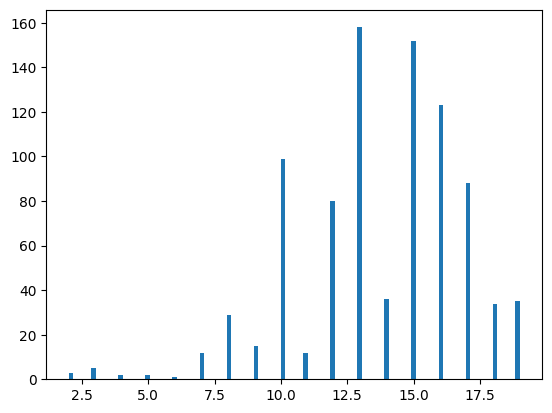

In [48]:
import matplotlib.pyplot as plt

l = [len(d.page_content) for d in all_docs]
plt.hist([ll for ll in l if ll < 20], bins=100)

In [49]:
# Loader metadata analysis

all = {}
for doc in all_docs:
    for key, value in doc.metadata.items():
        if key not in all.keys():
            all[key] = [value]
        else:
            all[key].append(value)

In [50]:
l = [len(d.page_content) for d in all_docs]
max(l)
l.index(max(l))
print(all_docs[l.index(max(l))].page_content)
print(all_docs[l.index(max(l))].metadata)

As the main requirement in carrying out my invention is to produce currents of an excessively-high potential, this object will be facilitated by using a primary current of very considerable frequency, since the electromotive force obtainable with a given length of conductor is proportionate to the frequency; but the frequency of the current is in a large measure arbitrary, for if the potential be sufficiently high and if the terminals of the coils be maintained at the proper altitudes the action described will take place, and a current will be transmitted through the elevated air strata, which will encounter little and possibly even less resistance than if conveyed through a copper wire of a practicable size. Accordingly the construction of the apparatus may be in many details greatly varied; but in order to enable any person skilled in the mechanical and electrical arts to utilize to advantage in the practical applications of my system the experience I have so far gained the following

In [51]:
all_metadata_keys = list(all.keys())
print(all_metadata_keys)
possible_categories = set(all['category'])
print([possible_categories])

for doc in all_docs:
    # if 'emphasized_text_contents' in doc.metadata.keys() and len(doc.metadata['emphasized_text_contents']) > 1:
    if 'filename' in doc.metadata.keys() and doc.metadata['filename'] == 'Experiments with Alternate Currents of High Potential and High Frequency.docx':    
        # print(doc.metadata['emphasized_text_contents'])
        print(doc.metadata)


['filename', 'page_number', 'category', 'id', 'title', 'date', 'type', 'header_footer_type', 'register_num']
[{'Title', 'Header', 'UncategorizedText', 'NarrativeText'}]


In [52]:
# Metadata parsing

import json

metadata_dict = {}
metadatas = json.load(open('metadata.json'))

ascii_replace_dict = {'â€™': '’', 'â€œ': '“', 'â€': '”'}
def replace_non_ascii(s):
    for pair_k, pair_v in ascii_replace_dict.items():
        s = s.replace(pair_k, pair_v)
    return s

for metadata in metadatas[2]['data']:
    if metadata['id'] in ['228', '413']:
        # These are duplicates, not needed
        continue
    key = ''.join(metadata['file_url'].split('/')[-1].rsplit('.', 1)[:-1])

    # Repalce non-ascii characters in key
    key = replace_non_ascii(key)
    
    # Make sure that there are no duplicate entries for the same document type
    if (key in metadata_dict.keys() and metadata['type'] == metadata_dict[key]['type']):
        print(key)
        print(metadata['id'])
    assert not (key in metadata_dict.keys() and metadata['type'] == metadata_dict[key]['type'])
    metadata_dict[key] = {key: value for key, value in metadata.items() if value is not None}
    
    # Replace non-ascii characters in file url
    del metadata_dict[key]['file_url']
    for m_key, m_value in metadata_dict.items():
        if m_value is None:
            del metadata_dict[m_key]
        


In [53]:
# Adding metadata

for doc in all_docs:
    assert doc.metadata['filename'][:-5] in metadata_dict.keys()
    doc.metadata.update(metadata_dict[doc.metadata['filename'][:-5]])

In [54]:
# Vectorstore creation

from langchain.vectorstores import Chroma

vectorstore = Chroma.from_documents(
    documents = all_docs,
    embedding = embeddings,
    persist_directory="./chroma_db"
)

In [ ]:
# Vectorstore loading

vectorstore = Chroma(persist_directory="./chroma_db", embedding_function = embeddings)

In [ ]:
from langchain.chains.query_constructor.base import AttributeInfo
from langchain.retrievers.self_query.base import SelfQueryRetriever


# TODO: add new metadata
metadata_field_info = [
    AttributeInfo(
        name="document_name",
        description="Name of the source document",
        type="string",
    ),
    AttributeInfo(
        name="id",
        description="Document ID",
        type="string",
    ),
    AttributeInfo(
        name="title",
        description="Title of the document",
        type="string",
    ),
    AttributeInfo(
        name="date",
        description="When the document was created",
        type="string",
    ),
    AttributeInfo(
        name="register_num",
        description="Patent registration number",
        type="string",
    ),
    AttributeInfo(
        name="source",
        description="Source of the document",
        type="string",
    ),
    AttributeInfo(
        name="type",
        description="Type of the document - options are lecture, article, patent",
        type="string",
    )
]

document_content_description = "Document content"

retriever = SelfQueryRetriever.from_llm(
    llm = llm, 
    vectorstore = vectorstore,
    document_contents = document_content_description,
    metadata_field_info = metadata_field_info, 
    verbose=True
)

In [55]:
docs = retriever.get_relevant_documents("What lectures did Nikola Tesla give")

NameError: name 'retriever' is not defined

In [ ]:
[d.metadata['filename'] for d in docs]

['Experiments With Alternate Currents of High Potential and High Frequency (lecture)',
 '7 On Electricity (lecture)',
 'Experiments With Alternating Currents of Very High Frequency and Their Application to Methods of Artificial Illumination (lecture)',
 '6 On Mechanical and Electrical Oscillators (lecture)']

In [ ]:
# Basic Retriever example

from langchain.chains import RetrievalQA

question = "How many poles shoul my electromotor have, and what should I do if I have the wrong number?"
qa_chain = RetrievalQA.from_chain_type(llm = llm, retriever = retriever)
print(qa_chain({"query": question}))

In [ ]:
# Retriever with memory example

from langchain.memory import ConversationBufferMemory
from langchain.chains import ConversationalRetrievalChain

memory = ConversationBufferMemory(memory_key = "chat_history", return_messages = True)
retriever = vectorstore.as_retriever()
qa = ConversationalRetrievalChain.from_llm(llm = llm, retriever = retriever, memory = memory)
question = input()
print(f"Question: {question}")
print(f"Answer: {qa({'question': question})['answer']}")
question = input()
print(f"Question: {question}")
print(f"Answer: {qa({'question': question})['answer']}")

Question: Did Nikola Tesla teach about light?
Answer: Yes, Nikola Tesla did discuss light in his lecture. He mentioned the electromagnetic theory of light and expressed his belief that electromagnetic waves, unless they had the frequency of true light waves, could not produce luminous effects. However, he believed that electrostatic waves could excite luminous radiation.
Question: When did he give that lecture and where?
Answer: Nikola Tesla gave the lecture discussing light at the Ellicot Club in Buffalo on January 12, 1897.
